In [1]:
library(readr)
library(qqman)
library(dplyr)
library(ggplot2)
library(data.table)



For example usage please run: vignette('qqman')



Citation appreciated but not required:

Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




# Load Genes

In [2]:
# 0. Read your annotation & prune files
genes <- read_tsv(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/Annotations_File/ukb_genoHM3.annot.genesymbol_mapped.pvar.gz"
) %>%
  mutate(
    ID          = toupper(as.character(ID)),
    in_LDSC_hm3 = as.logical(in_LDSC_hm3)
  )

prune_df <- fread(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Reference_Files/LD_Inclusion/ukb_genoHM3.WB.8r2.prune.in",
  header    = FALSE,
  col.names = "SNP"
)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 1316181 Columns: 26
── Column specification ─────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): #CHROM, ID, REF, ALT, FILTER, geno_source, ID_UKB, Existing_variat...
dbl  (6): POS, UKB_all_missing, UKB_all_OBSCT, UKB_WB_AF, gnomAD_NFE_AF, HWE_p
lgl  (2): in_LDSC_hm3, liftOver_unmapped_reason

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Loneliness

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


[1] 1316181


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


[1] 728883


Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”


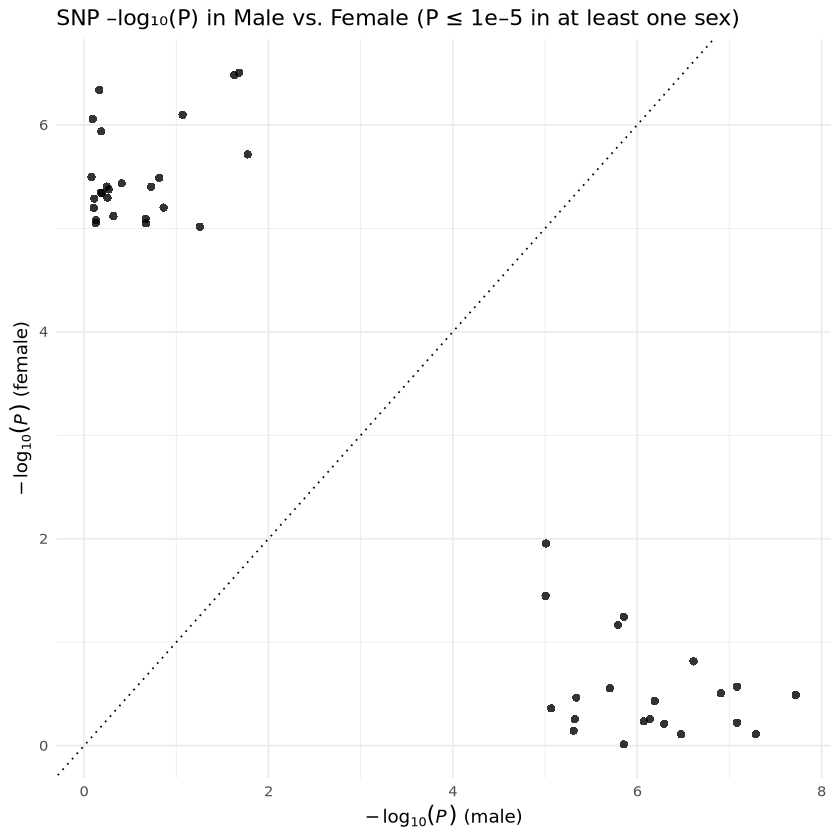

In [3]:
library(readr)
library(dplyr)
library(ggplot2)
library(data.table)

# 1. prep_gwas without the P<=1e-3 filter
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(SNP = ID, CHR = `#CHROM`, BP = POS) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID"))
}

print(length(prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Male/Loneliness.glm.tsv.gz"
)$SNP))

# 2. Read & annotate each sex, then keep only prune-list SNPs
male_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Male/Loneliness.glm.tsv.gz"
) %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

print(length(male_all$SNP))

female_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/loneliness/WB_Female/Loneliness.glm.tsv.gz"
) %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

# 3. Merge & filter on P_male<=1e-3 OR P_female<=1e-5, then compute –log10(P)
dt <- full_join(male_all, female_all, by = "SNP") %>%
  filter(
    ( !is.na(P_male)   & P_male   <= 1e-5 ) |
    ( !is.na(P_female) & P_female <= 1e-5 )
  ) %>%
  mutate(
    logP_male   = -log10(P_male),
    logP_female = -log10(P_female)
  )

# 4. Plot as before
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +
  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (P ≤ 1e–5 in at least one sex)"
  ) +
  theme_minimal()


Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


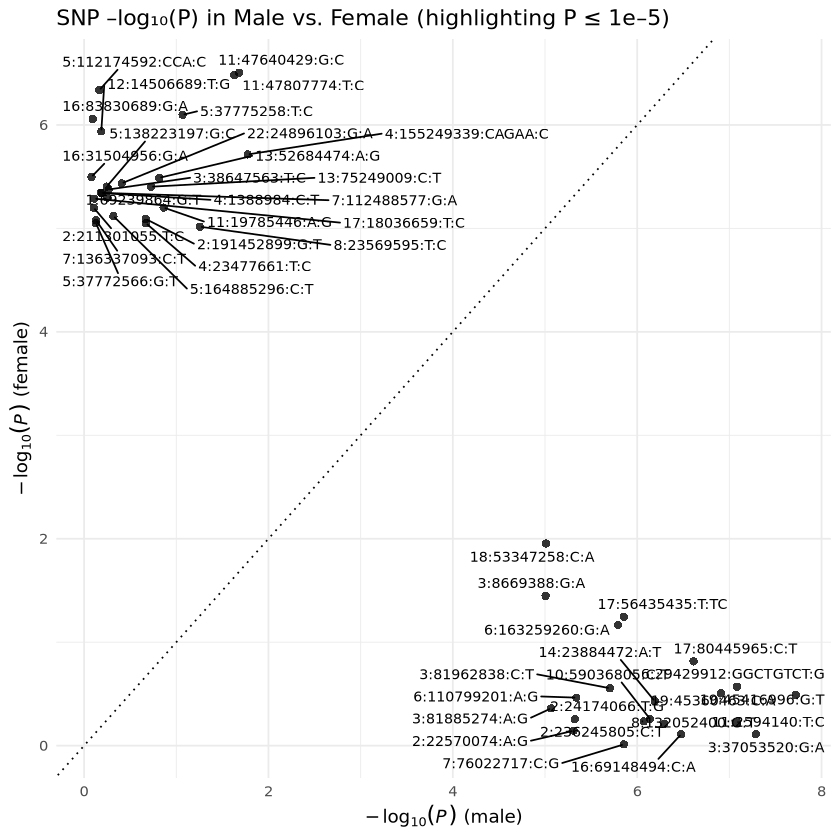

In [4]:
# at the top, load ggrepel
library(ggrepel)

# define your P‐value threshold
p_thresh <- 1e-5

# flag which SNPs to label
dt <- dt %>%
  mutate(
    label_this = (P_male   <= p_thresh) |
                 (P_female <= p_thresh)
  )

# now plot, adding geom_text_repel on the subset
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +

  # only label SNPs where label_this is TRUE
  geom_text_repel(
    data = subset(dt, label_this),
    aes(label = SNP),
    size    = 3,
    max.overlaps = Inf
  ) +

  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (highlighting P ≤ 1e–5)"
  ) +
  theme_minimal()


In [5]:
female_top20 <- female_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_female, n = 20, with_ties = FALSE)

male_top20 <- male_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_male, n = 20, with_ties = FALSE)

In [6]:
# ensure directories exist
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males",
           recursive = TRUE, showWarnings = FALSE)
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females",
           recursive = TRUE, showWarnings = FALSE)

# save the top‐20 tables
write_csv(
  male_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males/Male_top20_Loneliness.csv"
)

write_csv(
  female_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females/Female_top20_Loneliness.csv"
)


# Ability To Confide

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”


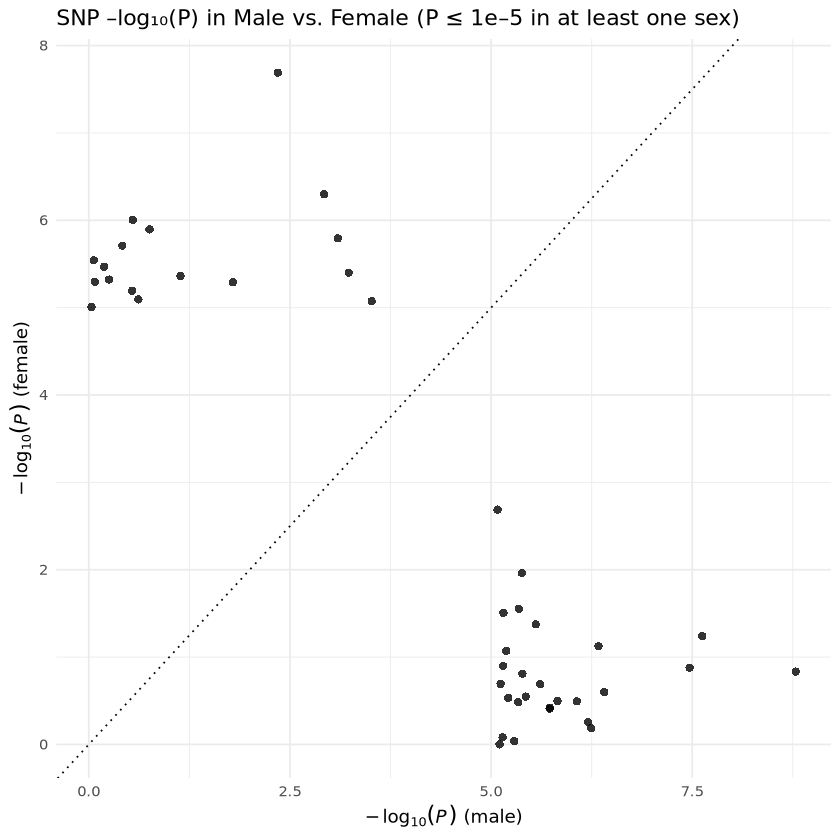

In [7]:
library(readr)
library(dplyr)
library(ggplot2)
library(data.table)

# 1. prep_gwas without the P<=1e-3 filter
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(SNP = ID, CHR = `#CHROM`, BP = POS) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID"))
}

# 2. Read & annotate each sex, then keep only prune-list SNPs
male_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Male/AbilityToConfide.glm.tsv.gz"
) %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

female_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/AbilityToConfide/WB_Female/AbilityToConfide.glm.tsv.gz"
) %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

# 3. Merge & filter on P_male<=1e-5 OR P_female<=1e-3, then compute –log10(P)
dt <- full_join(male_all, female_all, by = "SNP") %>%
  filter(
    ( !is.na(P_male)   & P_male   <= 1e-5 ) |
    ( !is.na(P_female) & P_female <= 1e-5 )
  ) %>%
  mutate(
    logP_male   = -log10(P_male),
    logP_female = -log10(P_female)
  )

# 4. Plot as before
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +
  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (P ≤ 1e–5 in at least one sex)"
  ) +
  theme_minimal()


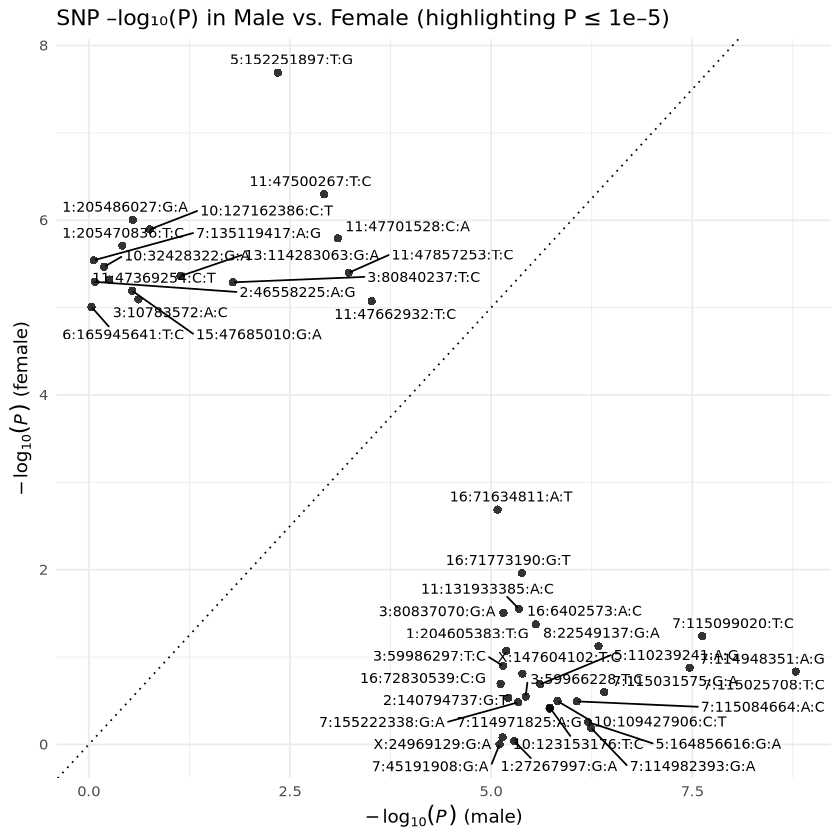

In [8]:
# at the top, load ggrepel
library(ggrepel)

# define your P‐value threshold
p_thresh <- 1e-5

# flag which SNPs to label
dt <- dt %>%
  mutate(
    label_this = (P_male   <= p_thresh) |
                 (P_female <= p_thresh)
  )

# now plot, adding geom_text_repel on the subset
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +

  # only label SNPs where label_this is TRUE
  geom_text_repel(
    data = subset(dt, label_this),
    aes(label = SNP),
    size    = 3,
    max.overlaps = Inf
  ) +

  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (highlighting P ≤ 1e–5)"
  ) +
  theme_minimal()


In [9]:
female_top20 <- female_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_female, n = 20, with_ties = FALSE)

male_top20 <- male_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_male, n = 20, with_ties = FALSE)

In [10]:
# ensure directories exist
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males",
           recursive = TRUE, showWarnings = FALSE)
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females",
           recursive = TRUE, showWarnings = FALSE)

# save the top‐20 tables
write_csv(
  male_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males/Male_top20_AbToConfide.csv"
)

write_csv(
  female_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females/Female_top20_AbToConfide.csv"
)


# Leisure And Social Activities

In [16]:
colnames(male_all)

[1] "CHR"                         "BP"                         
 [3] "SNP"                         "REF.x"                      
 [5] "ALT.x"                       "PROVISIONAL_REF?"           
 [7] "A1"                          "OMITTED"                    
 [9] "A1_FREQ"                     "TEST"                       
[11] "OBS_CT"                      "BETA"                       
[13] "SE"                          "T_STAT"                     
[15] "LOG10_P"                     "ERRCODE"                    
[17] "P_male"                      "#CHROM"                     
[19] "POS"                         "REF.y"                      
[21] "ALT.y"                       "FILTER"                     
[23] "geno_source"                 "ID_UKB"                     
[25] "Existing_variation"          "in_LDSC_hm3"                
[27] "Csq_group"                   "Consequence"                
[29] "Gene_symbol"                 "Gene_ID"                    
[31] "LoF"                         "ClinVar"                    
[33] "ClinVar_raw"                 "UKB_all_missing"            
[35] "UKB_all_OBSCT"               "UKB_WB_AF"                  
[37] "gnomAD_NFE_AF"               "HWE_p"                      
[39] "liftOver_unmapped_reason"    "Gene_symbol_original"       
[41] "Existing_variation_original" "plot_label"

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `CHR = case_when(CHR == "X" ~ 23L, CHR == "Y" ~ 24L, TRUE ~ as.integer(CHR))`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”


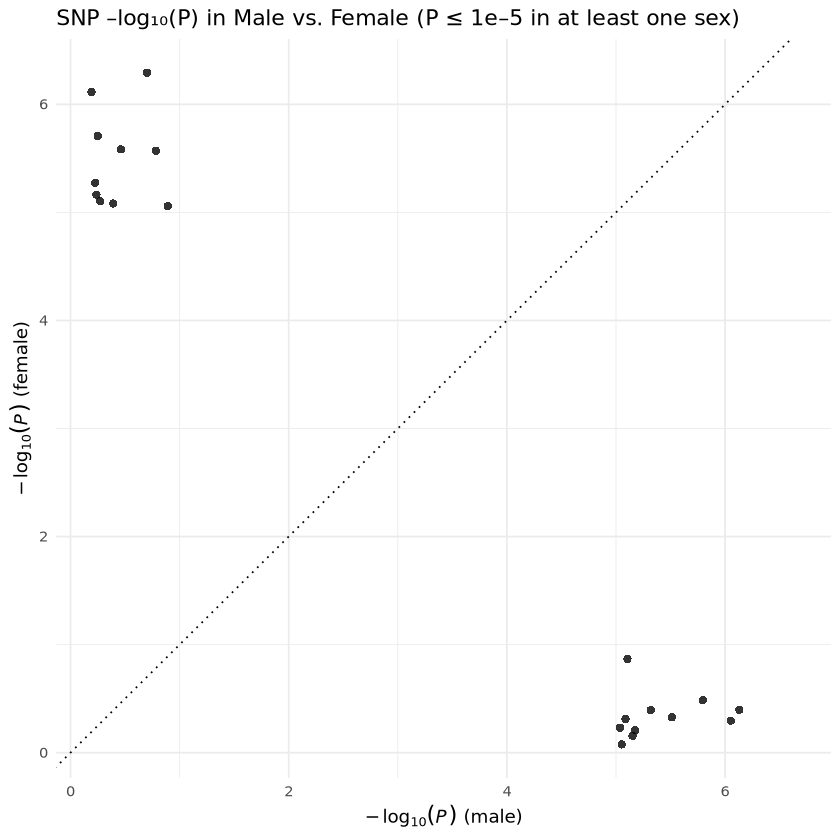

In [11]:
library(readr)
library(dplyr)
library(ggplot2)
library(data.table)

# 1. prep_gwas without the P<=1e-3 filter
prep_gwas <- function(path) {
  read_tsv(path, col_types = cols()) %>%
    rename(SNP = ID, CHR = `#CHROM`, BP = POS) %>%
    mutate(
      P   = 10^(-LOG10_P),
      SNP = toupper(SNP),
      CHR = case_when(
        CHR == "X" ~ 23L,
        CHR == "Y" ~ 24L,
        TRUE       ~ as.integer(CHR)
      )
    ) %>%
    inner_join(genes, by = c("SNP" = "ID"))
}

# 2. Read & annotate each sex, then keep only prune-list SNPs
male_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Male/LeisureSocialActivities.glm.tsv.gz"
) %>% rename(P_male = P) %>% semi_join(prune_df, by = "SNP")

female_all <- prep_gwas(
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/MR_Final/Data/GWAS_Outs/Raw/LeisureSocialActivities/WB_Female/LeisureSocialActivities.glm.tsv.gz"
) %>% rename(P_female = P) %>% semi_join(prune_df, by = "SNP")

# 3. Merge & filter on P_male<=1e-3 OR P_female<=1e-5, then compute –log10(P)
dt <- full_join(male_all, female_all, by = "SNP") %>%
  filter(
    ( !is.na(P_male)   & P_male   <= 1e-5 ) |
    ( !is.na(P_female) & P_female <= 1e-5 )
  ) %>%
  mutate(
    logP_male   = -log10(P_male),
    logP_female = -log10(P_female)
  )

# 4. Plot as before
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +
  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (P ≤ 1e–5 in at least one sex)"
  ) +
  theme_minimal()


Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_text_repel()`).”


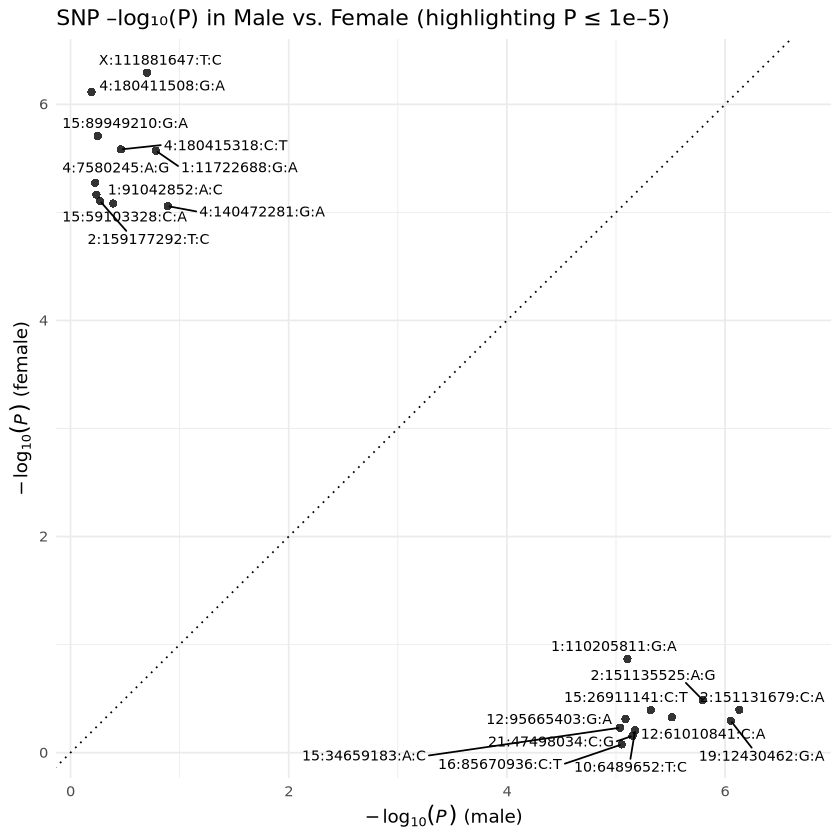

In [12]:
# at the top, load ggrepel
library(ggrepel)

# define your P‐value threshold
p_thresh <- 1e-5

# flag which SNPs to label
dt <- dt %>%
  mutate(
    label_this = (P_male   <= p_thresh) |
                 (P_female <= p_thresh)
  )

# now plot, adding geom_text_repel on the subset
ggplot(dt, aes(x = logP_male, y = logP_female)) +
  geom_point(shape = 16, size = 2, alpha = 0.8) +
  geom_abline(intercept = 0, slope = 1, linetype = "dotted") +

  # only label SNPs where label_this is TRUE
  geom_text_repel(
    data = subset(dt, label_this),
    aes(label = SNP),
    size    = 3,
    max.overlaps = Inf
  ) +

  labs(
    x     = expression(-log[10](italic(P))~"(male)"),
    y     = expression(-log[10](italic(P))~"(female)"),
    title = "SNP –log₁₀(P) in Male vs. Female (highlighting P ≤ 1e–5)"
  ) +
  theme_minimal()


In [13]:
female_top20 <- female_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_female, n = 20, with_ties = FALSE)

male_top20 <- male_all %>%
  semi_join(prune_df, by = "SNP") %>%
  slice_min(order_by = P_male, n = 20, with_ties = FALSE)

In [14]:
# ensure directories exist
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males",
           recursive = TRUE, showWarnings = FALSE)
dir.create("/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females",
           recursive = TRUE, showWarnings = FALSE)

# save the top‐20 tables
write_csv(
  male_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Males/Male_top20_Leisure.csv"
)

write_csv(
  female_top20,
  "/om2/user/mabdel03/files/Isolation/Genetics_Work/GWAS/Outputs/CORRECTED_TopSNPs/Females/Female_top20_Leisure.csv"
)
